<a href="https://colab.research.google.com/github/Mapc1/vcpi-individual-23/blob/main/landscape_coloring_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 15.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip '/content/drive/MyDrive/landscape-color.zip' -d 'landscape-color'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: landscape-color/landscape Images/gray/2914.jpg  
  inflating: landscape-color/landscape Images/gray/2915.jpg  
  inflating: landscape-color/landscape Images/gray/2916.jpg  
  inflating: landscape-color/landscape Images/gray/2917.jpg  
  inflating: landscape-color/landscape Images/gray/2918.jpg  
  inflating: landscape-color/landscape Images/gray/2919.jpg  
  inflating: landscape-color/landscape Images/gray/292.jpg  
  inflating: landscape-color/landscape Images/gray/2920.jpg  
  inflating: landscape-color/landscape Images/gray/2921.jpg  
  inflating: landscape-color/landscape Images/gray/2922.jpg  
  inflating: landscape-color/landscape Images/gray/2923.jpg  
  inflating: landscape-color/landscape Images/gray/2924.jpg  
  inflating: landscape-color/landscape Images/gray/2925.jpg  
  inflating: landscape-color/landscape Images/gray/2926.jpg  
  inflating: landscape-color/landscape Images/gray/2927.jpg  
  inflating:

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Reshape,
    Flatten,
    Dense,
    BatchNormalization,
    LeakyReLU,
    Input,
    Dropout,
    Activation,
    MaxPool2D,
    Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE
from keras.utils import plot_model
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard
)
import tensorflow_addons as tfa

from PIL import Image
import numpy as np
from IPython.display import clear_output

import matplotlib.pyplot as plt

import glob
import os
import time
import math

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Constants

In [12]:
BUFFER_SIZE = 5
BATCH_SIZE = 32
LATENT_DIM = 256
DS_PATH = '/content/datasets/landscape-image-colorization/landscape Images'
EXTRA_DS_PATH = '/kaggle/input/landscape-pictures'
SAVE_IMGS_PATH = '/kaggle/working/generated_images'

EPOCHS_TO_KEEP_IMGS = 10

LAMBDA = 100

TEST_SIZE = 16
IN_CHANNELS = 1
OUT_CHANNELS = 3
EPOCHS = 50
NUM_EXAMPLES=16
LATENT_DIM = 10
WIDTH=128
HEIGHT=128
PATIENCE=5

READ_ONLINE = True
READ_EXTRA_ONLINE = False
TRAIN_ONLINE = True

# Auxiliary functions

In [8]:
def show_batch(image_batch, cmap='viridis', vmin=0, vmax=1):
    columns = 8
    rows = len(image_batch) / columns + 1
    plt.figure(figsize=(16, 2 * rows))
    for n in range(len(image_batch)):
        ax = plt.subplot(int(rows), columns, n+1)
        plt.imshow((image_batch[n]), vmin=vmin, vmax=vmax, cmap=cmap)
        plt.axis('off')


def generate_and_save_images(model, epoch, test_input, target_imgs):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig, axes = plt.subplots(NUM_EXAMPLES,3)
    fig.set_size_inches(10,50)
    for i in range(NUM_EXAMPLES):
        img_pos1 = axes[i,0]
        img_pos1.set_title(f'Input')
        img_pos1.axis('off')
        img_pos1.imshow(test_input[i], cmap='gray')

        img_pos2 = axes[i,1]
        img_pos2.set_title(f'Target')
        img_pos2.axis('off')
        img_pos2.imshow(target_imgs[i])

        img_pos3 = axes[i,2]
        img_pos3.set_title(f'Prediction')
        img_pos3.axis('off')
        img_pos3.imshow(predictions[i])

    plt.savefig('{folder}/image_at_epoch_{epoch:04d}.png'.format(folder=SAVE_IMGS_PATH, epoch=epoch))
    plt.show()

    if epoch > EPOCHS_TO_KEEP_IMGS: # Keep only last EPOCHS_TO_KEEP_IMGS epochs
        epoch_to_remove = epoch - EPOCHS_TO_KEEP_IMGS
        os.remove('{folder}/image_at_epoch_{epoch:04d}.png'.format(folder=SAVE_IMGS_PATH, epoch=epoch_to_remove))

In [9]:
os.makedirs(SAVE_IMGS_PATH, exist_ok=True)

# Read dataset

In [10]:
@tf.function
def read_img(img_path):
    raw_img = tf.io.read_file(img_path)
    color_img = tf.io.decode_jpeg(raw_img, channels=3)
    color_img = tf.image.convert_image_dtype(color_img, tf.float32)
    color_img = tf.image.resize(color_img, (150,150))

    rotation = tf.random.uniform(shape=(), minval=0, maxval=1) - 0.5
    color_img = tfa.image.rotate(color_img,rotation)
    color_img = tf.image.random_crop(color_img, size=(HEIGHT,WIDTH,3))

    gray_img = tf.image.rgb_to_grayscale(color_img)

    return gray_img, color_img

@tf.function
def preprocess_extra_img(img_path):
    raw_img = tf.io.read_file(img_path)
    color_img = tf.io.decode_jpeg(raw_img, channels=3)
    color_img = tf.image.convert_image_dtype(color_img, tf.float32)
    color_img = tf.image.resize(color_img, size=(256,256))

    rotation = tf.random.uniform(shape=(), minval=0, maxval=1) - 0.5
    color_img = tfa.image.rotate(color_img,rotation)
    color_img = tf.image.random_crop(color_img, size=(HEIGHT,WIDTH,3))

    gray_img = tf.image.rgb_to_grayscale(color_img)

    return gray_img, color_img

In [13]:
if READ_ONLINE:
    files = tf.data.Dataset.list_files(f'{DS_PATH}/color/*.jpg')
    dataset = files.map(read_img, num_parallel_calls=AUTOTUNE)

    if READ_EXTRA_ONLINE:
        extra_files = tf.data.Dataset.list_files(f'{EXTRA_DS_PATH}/*.jpg')
        extra_ds = extra_files.map(preprocess_extra_img, num_parallel_calls=AUTOTUNE)

        dataset = dataset.concatenate(extra_ds)

    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)

    # We will use one batch to test the output of our model
    test_batch = next(iter(dataset))[:][:NUM_EXAMPLES]

    train_ds = dataset.skip(1)

    train_ds = train_ds.cache()
    train_ds = train_ds.prefetch(buffer_size=BUFFER_SIZE)

# View dataset images

In [14]:
if READ_EXTRA_ONLINE:
    extra_ds = extra_ds.batch(BATCH_SIZE)
    image_batch = next(iter(extra_ds))
    num_batches = extra_ds.cardinality().numpy()

    print(f'Input Batch shape: {image_batch[0].numpy().shape}')
    print(f'Output Batch shape: {image_batch[1].numpy().shape}')
    print(f'Number of batches: {num_batches}')
    show_batch(image_batch[0], cmap='gray')
    show_batch(image_batch[1])

Input Batch shape: (32, 128, 128, 1)
Output Batch shape: (32, 128, 128, 3)
Number of batches: 222


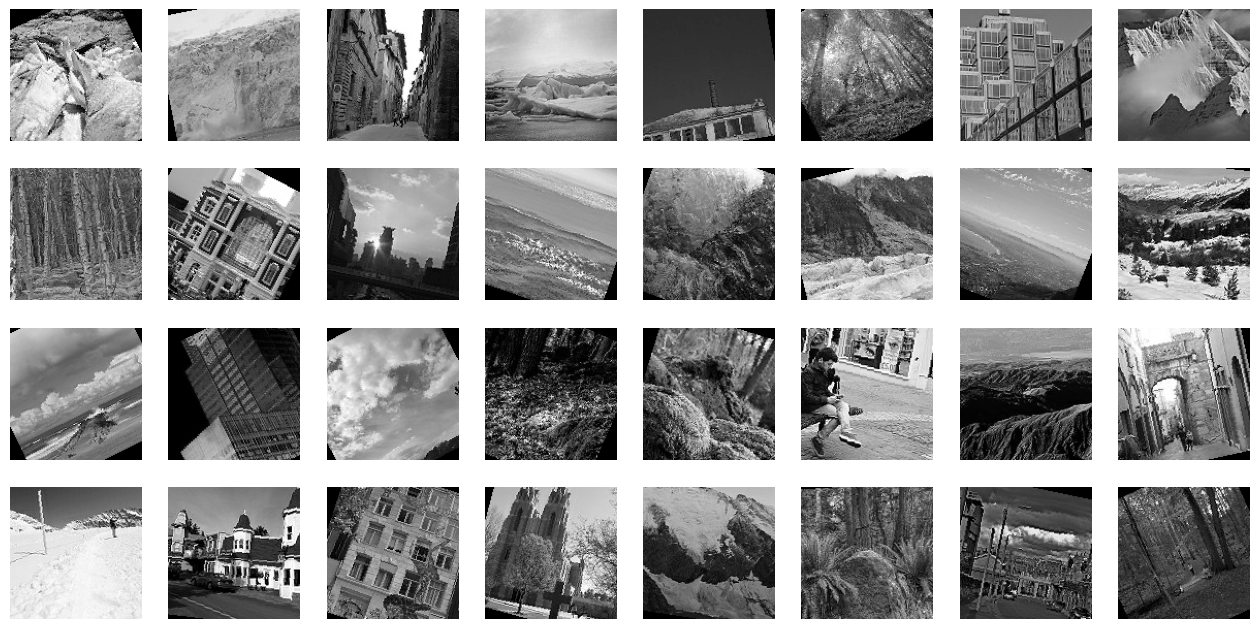

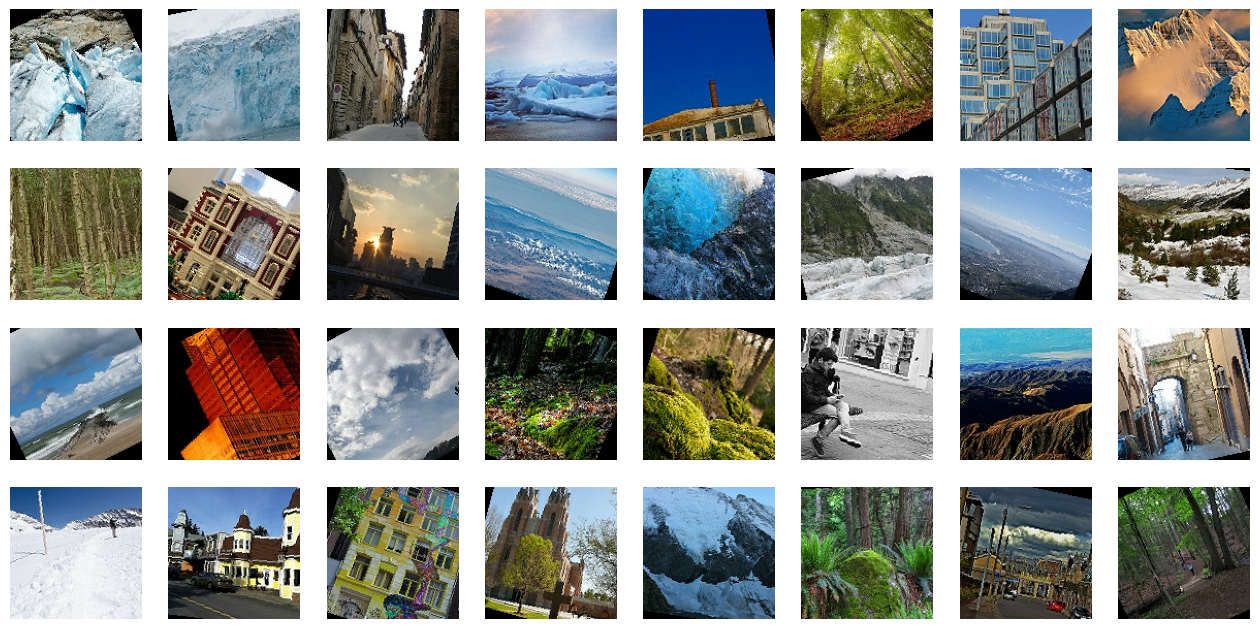

In [15]:
image_batch = next(iter(train_ds))
num_batches = train_ds.cardinality().numpy()

print(f'Input Batch shape: {image_batch[0].numpy().shape}')
print(f'Output Batch shape: {image_batch[1].numpy().shape}')
print(f'Number of batches: {num_batches}')
show_batch(image_batch[0], cmap='gray')
show_batch(image_batch[1])

# Encoder and decoder

In [16]:
def make_autoencoder():
    inputs = Input(shape=(HEIGHT,WIDTH,IN_CHANNELS))

    encoder = Conv2D(64, (5,5), strides=2, padding='same')(inputs)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    conv1 = Dropout(0.2)(encoder)

    encoder = Conv2D(128, (5,5), strides=2, padding='same')(conv1)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    conv2 = Dropout(0.2)(encoder)

    encoder = Conv2D(256, (5,5), strides=2, padding='same')(conv2)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    conv3 = Dropout(0.2)(encoder)

    encoder = Conv2D(512, (5,5), strides=2, padding='same')(conv3)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    conv4 = Dropout(0.2)(encoder)

    #shape = conv4.shape

    encoder = Conv2D(512, (5,5), strides=2, padding='same')(conv4)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    encoder = Dropout(0.2)(encoder)

    decoder = Conv2DTranspose(512, (5,5), strides=2, padding='same')(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(alpha=0.2)(decoder)
    decoder = Dropout(0.2)(decoder)

    #encoder = Flatten()(conv4)
    #encoder = Dense(LATENT_DIM)(encoder)


    #decoder = Dense(shape[1]*shape[2]*shape[3])(encoder)
    #decoder = Reshape((shape[1], shape[2], shape[3]))(decoder)

    decoder = Concatenate()([decoder,conv4])
    decoder = Conv2DTranspose(256, (5,5), strides=2, padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(alpha=0.2)(decoder)
    decoder = Dropout(0.2)(decoder)

    decoder = Concatenate()([decoder,conv3])
    decoder = Conv2DTranspose(128, (5,5), strides=2, padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(alpha=0.2)(decoder)
    decoder = Dropout(0.2)(decoder)

    decoder = Concatenate()([decoder,conv2])
    decoder = Conv2DTranspose(64, (5,5), strides=2, padding='same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(alpha=0.2)(decoder)
    decoder = Dropout(0.2)(decoder)

    decoder = Concatenate()([decoder,conv1])
    decoder = Conv2DTranspose(OUT_CHANNELS, (5,5), strides=2, padding='same')(decoder)
    #decoder = BatchNormalization()(decoder)
    #decoder = LeakyReLU(alpha=0.2)(decoder)

    decoder = Activation('sigmoid')(decoder)

    autoencoder = Model(inputs, decoder, name='autoencoder')
    autoencoder.summary()

    return autoencoder

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1664        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                        

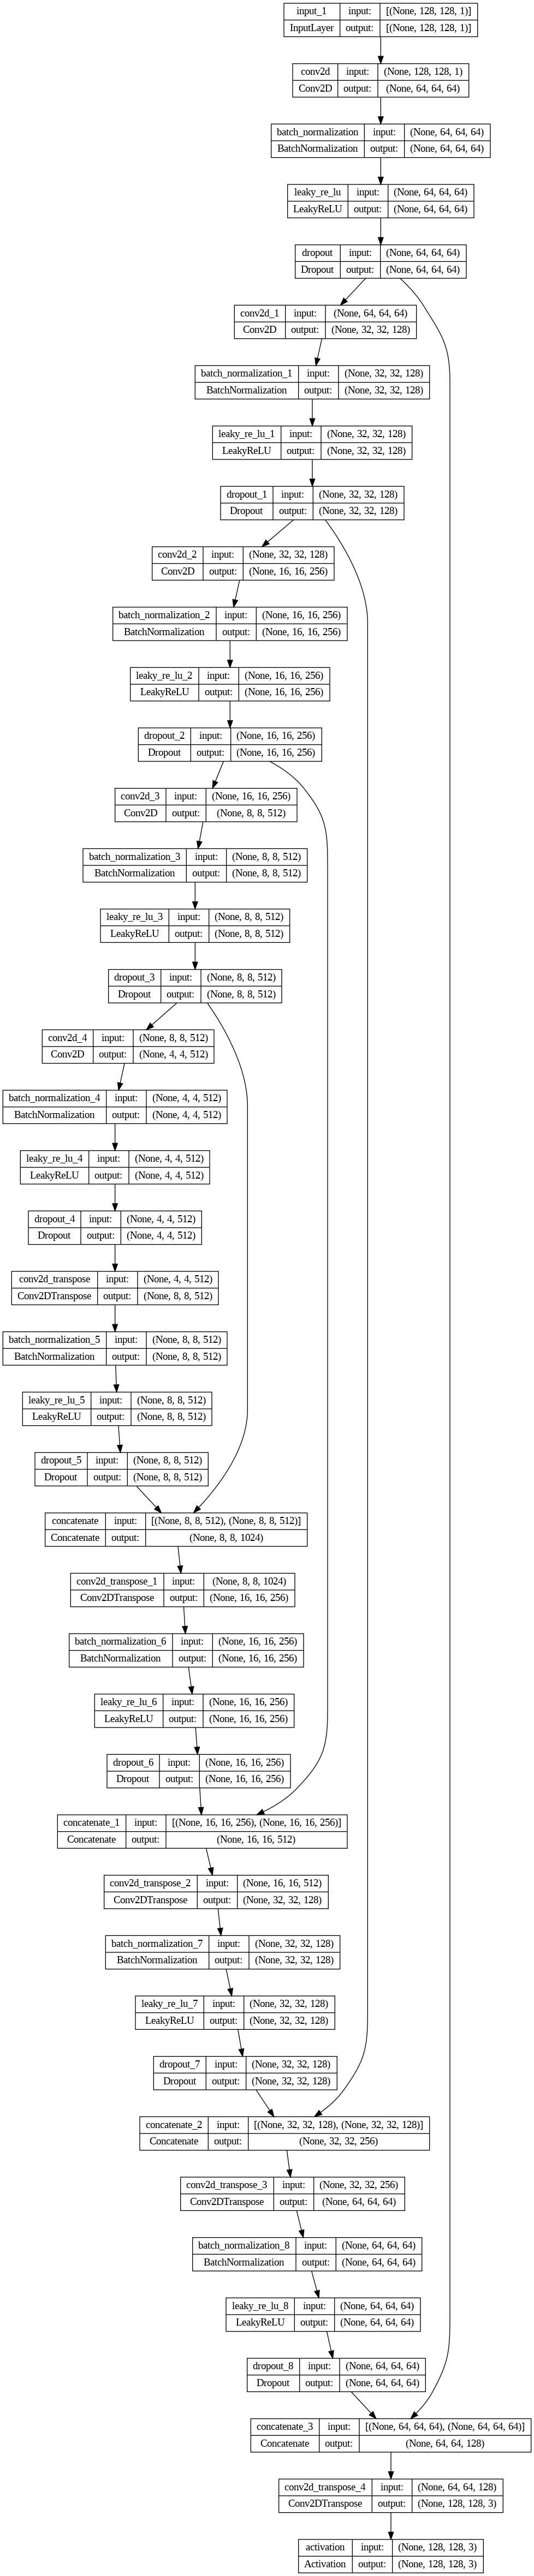

In [17]:
generator = make_autoencoder()
plot_model(generator, show_shapes=True)

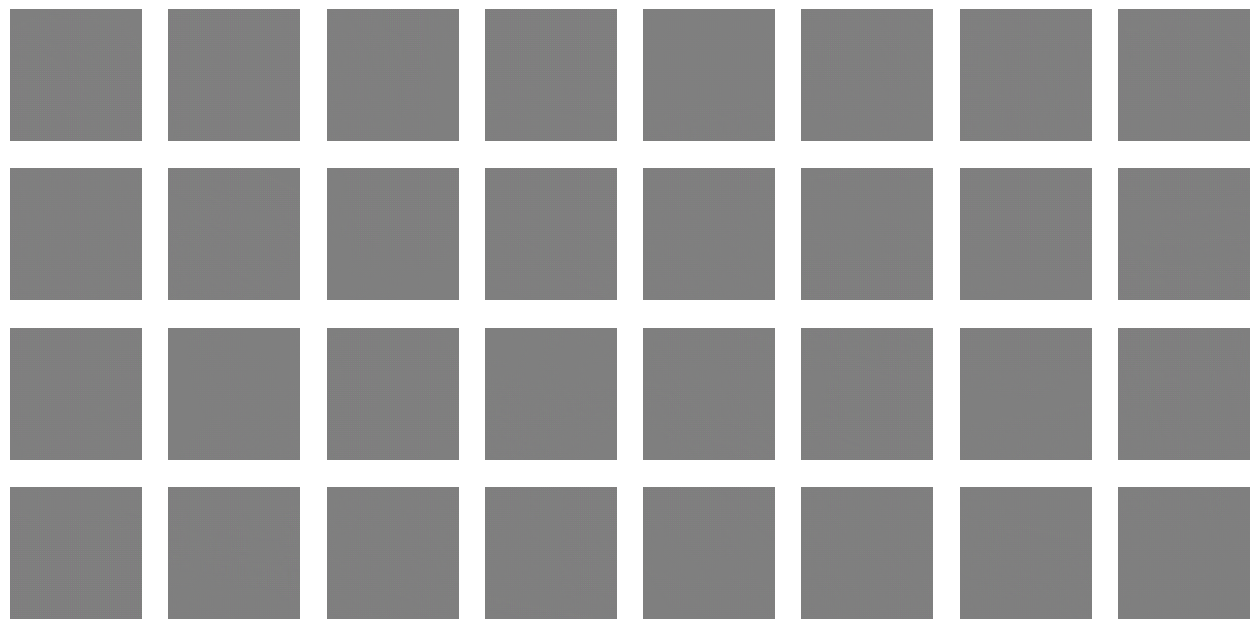

In [18]:
gen_output = generator(image_batch[0], training=False)
show_batch(gen_output)

In [19]:
loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)

In [20]:
def generator_loss(disc_gen_output, gen_output, target):
    gan_loss = loss(tf.ones_like(disc_gen_output), disc_gen_output)

    # MAE
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    return (LAMBDA * l1_loss) + gan_loss

In [21]:
def make_discriminator():
    #init = tf.random_normal_initializer(0,0.2)
    # Grayscale image
    input_image = Input(shape=(128,128,1), name='input_image')
    # Colored image (can be the target image or our generated image)
    target_image = Input(shape=(128,128,3), name='target_image')

    # The tf.layers.Concatenate layer does not work for some reason
    inputs = tf.keras.layers.concatenate([input_image, target_image])

    discriminator = Conv2D(16, (5,5), strides=2, padding='same')(inputs)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    discriminator = Dropout(0.2)(discriminator)

    discriminator = Conv2D(32, (5,5), strides=2, padding='same')(discriminator)
    discriminator = BatchNormalization()(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    discriminator = Dropout(0.2)(discriminator)

    discriminator = Conv2D(64, (5,5), strides=2, padding='same')(discriminator)
    discriminator = BatchNormalization()(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    discriminator = Dropout(0.2)(discriminator)

    discriminator = Conv2D(128, (5,5), strides=1, padding='same')(discriminator)
    discriminator = BatchNormalization()(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(1, (5,5), strides=1, padding='same')(discriminator)

    return Model(inputs=(input_image,target_image), outputs=discriminator)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 128, 128, 4)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']       

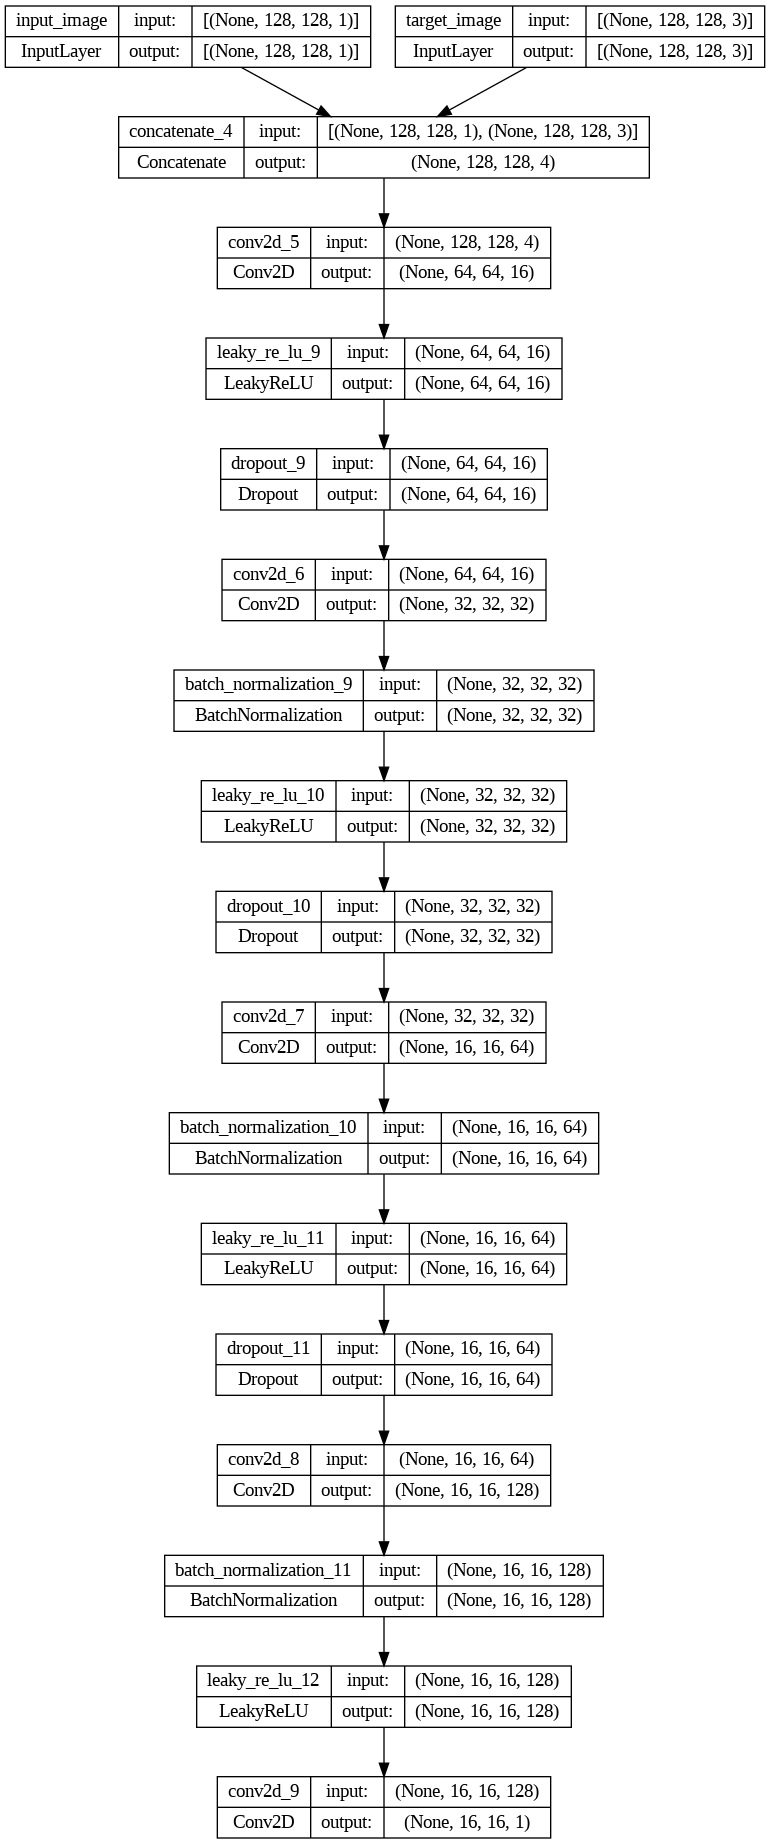

In [22]:
discriminator = make_discriminator()
discriminator.summary()
plot_model(discriminator, show_shapes=True)

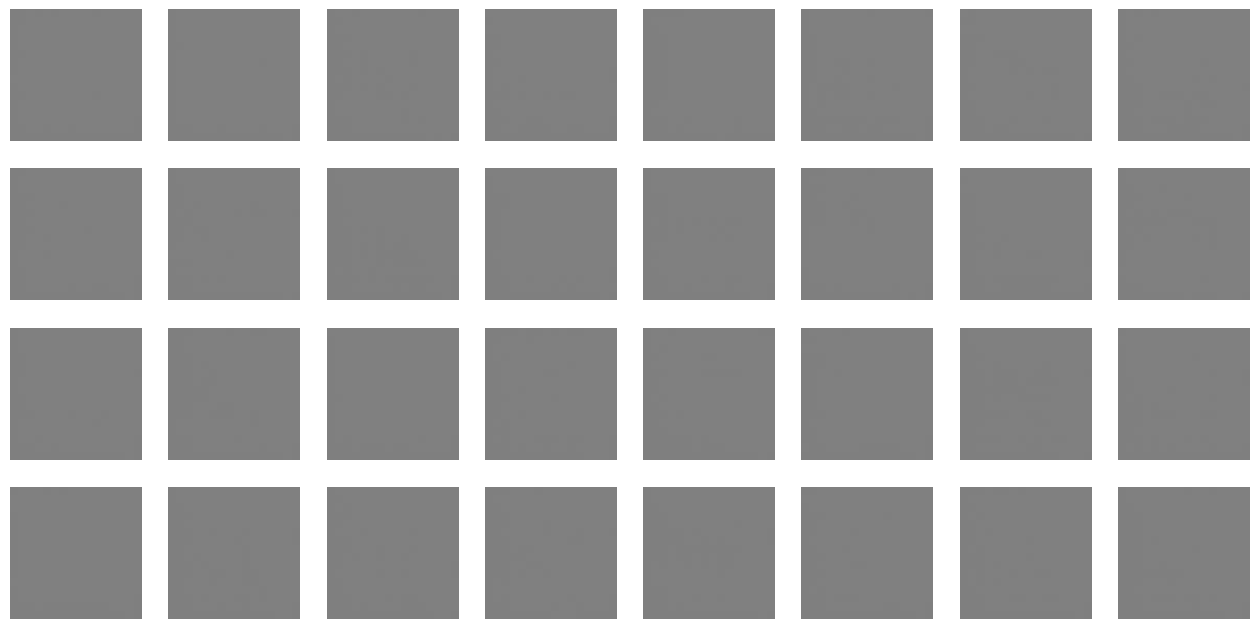

In [23]:
disc_output = discriminator((image_batch[0],gen_output), training=False)
#print(disc_output)
show_batch(disc_output, cmap='gray', vmin=-20, vmax=20)

In [24]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss(tf.ones_like(disc_real_output), disc_real_output)
    gen_loss = loss(tf.zeros_like(disc_gen_output), disc_gen_output)

    return real_loss + gen_loss

In [25]:
gen_opt = Adam(learning_rate=5e-4, beta_1=0.3)
disc_opt = Adam(learning_rate=5e-4, beta_1=0.3)

In [26]:
@tf.function
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_img, training=True)

        disc_real_output = discriminator((input_img, target_img), training=True)
        disc_gen_output = discriminator((input_img, gen_output), training=True)

        gen_loss = generator_loss(disc_gen_output, gen_output, target_img)
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gen_gradients,generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradients,discriminator.trainable_variables))

    return gen_loss, disc_loss

In [27]:
best_gen_loss = math.inf
best_disc_loss = math.inf

epochs_without_gen_loss_improv = 0
epochs_without_disc_loss_improv = 0

def reduce_lr_cb(avg_gen_loss, avg_disc_loss):
    global best_gen_loss, best_disc_loss, epochs_without_gen_loss_improv, epochs_without_disc_loss_improv

    if avg_gen_loss < best_gen_loss:
        best_gen_loss = avg_gen_loss
    else:
        epochs_without_gen_loss_improv += 1
        if epochs_without_gen_loss_improv >= PATIENCE:
            tf.keras.backend.set_value(gen_opt.learning_rate, gen_opt.learning_rate/2)
            print(f'Learning rate reduced to {gen_opt.learning_rate}')
            epochs_without_gen_loss_improv = 0

    if avg_disc_loss < best_disc_loss:
        best_disc_loss = avg_disc_loss
    else:
        epochs_without_disc_loss_improv += 1
        if epochs_without_disc_loss_improv >= PATIENCE:
            tf.keras.backend.set_value(disc_opt.learning_rate, disc_opt.learning_rate/2)
            print(f'Learning rate reduced to {disc_opt.learning_rate}')
            epochs_without_disc_loss_improv = 0

callbacks = [] #[reduce_lr_cb]

Epoch: 49
EPOCH GEN LOSS: 3.654982566833496
EPOCH DISC LOSS: 0.31311458349227905


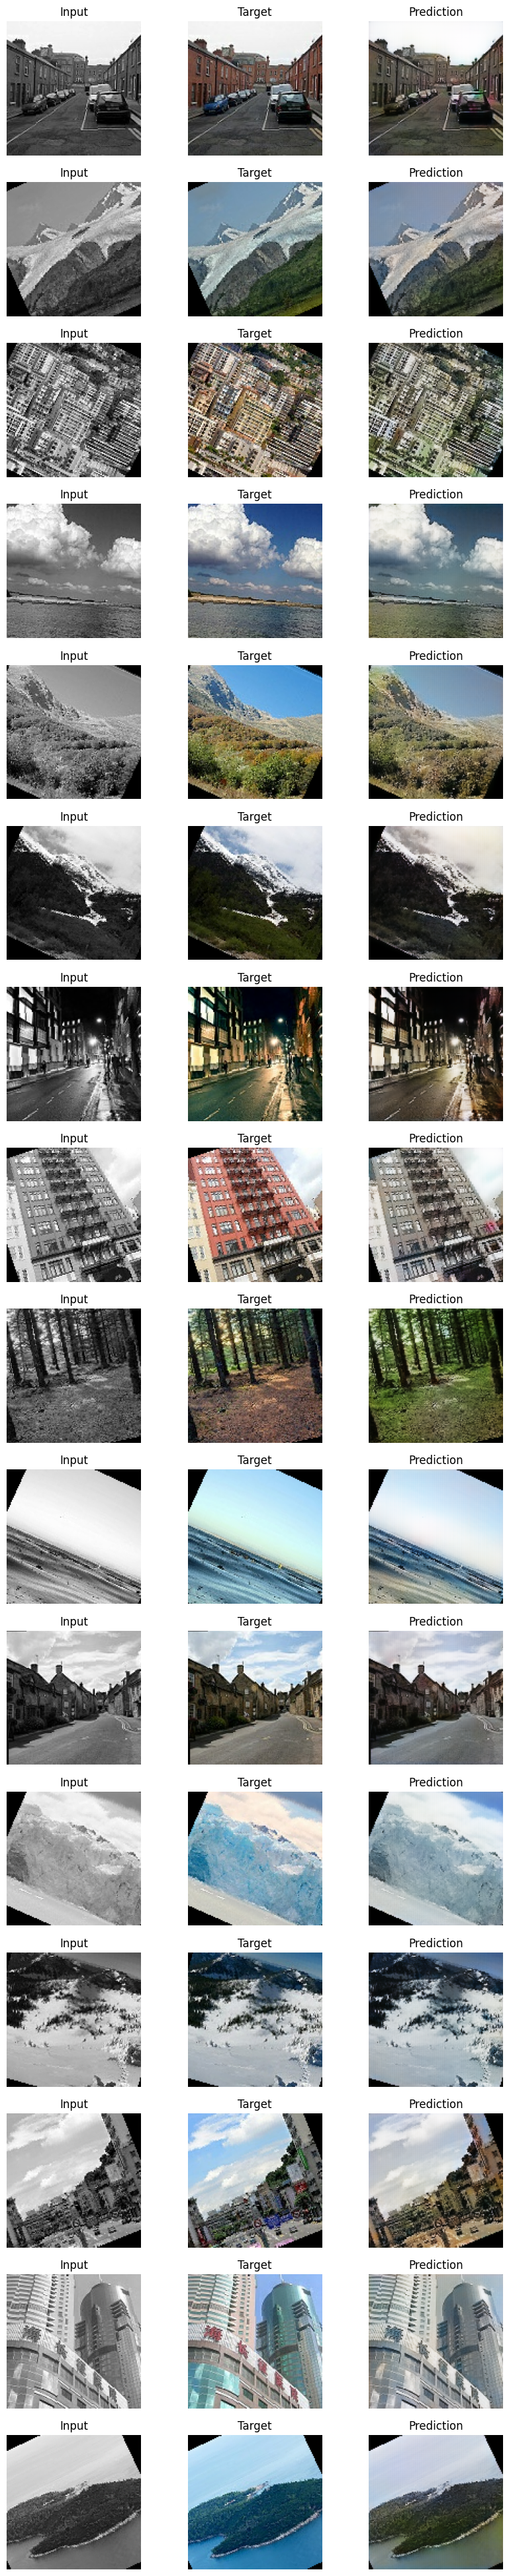

In [28]:
num_batches = train_ds.cardinality().numpy()


for epoch in range(EPOCHS):
    avg_disc_loss = 0
    avg_gen_loss = 0
    for batch in train_ds:
        gen_loss, disc_loss = train_step(batch[0], batch[1])
        avg_gen_loss += gen_loss
        avg_disc_loss += disc_loss

    avg_gen_loss /= num_batches
    avg_disc_loss /= num_batches

    clear_output()
    print(f'Epoch: {epoch}')
    print(f'EPOCH GEN LOSS: {avg_gen_loss}')
    print(f'EPOCH DISC LOSS: {avg_disc_loss}')

    generate_and_save_images(generator, epoch, test_batch[0], test_batch[1])

    for callback in callbacks:
        callback(avg_gen_loss,avg_disc_loss)